# Creation of annotations for hyperspectral colorchecker images

**Please do not commit changes to this notebook!**

The purpose of this notebook is to:
- provide a tool to automatically create masks for colorchecker images and doublecheck for their correctness (Part 1)
- provide a tutorial for troubleshooting in case manual finetuning of automatically created masks should be required (Part 2)

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

from htc.settings import settings
from htc.tivita.DataPath import DataPath
from htc.utils.ColorcheckerReader import ColorcheckerReader


def visualize_rotation(ccr: ColorcheckerReader):
    rgb_img = ccr.img_dir.read_rgb_reconstructed()
    area = ccr.automask_search_area()

    fig, ax = plt.subplots(ncols=2, tight_layout=True)
    ax[0].imshow(rgb_img)
    ax[0].set_title("Cube before deskewing")
    ax[0].axis("off")
    ax[1].imshow(ccr.rot_rgb)
    ax[1].imshow(area > 0, alpha=0.2)
    ax[1].set_title("Rotated cube")
    ax[1].axis("off")

    return fig

## Part 1: Automatic creation of colorchecker masks

The type of colorchecker board needs to be specified:
- If the [colorchecker classic](https://www.xrite.com/de/categories/calibration-profiling/colorchecker-classic) has been used, set cc_board to *"cc_classic"*
- If the [colorchecker classic mini](https://www.xrite.com/categories/calibration-profiling/colorchecker-classic-family/colorchecker-classic-mini) and the video color chips of the [colorchecker passport video](https://www.xrite.com/categories/calibration-profiling/colorchecker-passport-video) have been imaged next to each other, set cc_board to *"cc_passport"*

Furthermore, the path to the image directory needs to the specified.

In [2]:
cc_board = "cc_classic"
img_dir = (
    settings.data_dirs["HeiPorSPECTRAL"]
    / "extra_technical_validation/Tivita_0202-00118/2022_12_25_colorchecker/2022_12_25_20_45_29"
)

Please run the cell below and doublecheck whether a plausible rotation angle of the colorchecker board has been determined. Jump to Part 2 if the rotation angle requires correction.
> Note: The yellow area in the rotated cube denotes the search area of the algorithm, i.e. a square is placed at each marked position. If this area does not cover you colorchecker chips, an automatic detection is unlikely to work well. You may want to decrease the `square_dist_*` parameters in this case.

Determined rotation angle: 0.00°


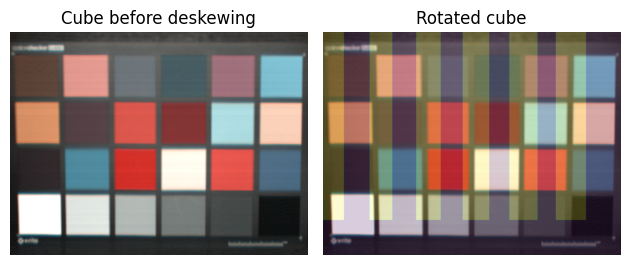

In [3]:
img_dir = DataPath(img_dir)
cc_reader = ColorcheckerReader(img_dir, cc_board)
print(f"Determined rotation angle: {cc_reader.rot_angle:.2f}°")
visualize_rotation(cc_reader);

By running the next cell, the colorchecker mask will be automatically generated. Please jump to Part 2, if the automask requires improvement.

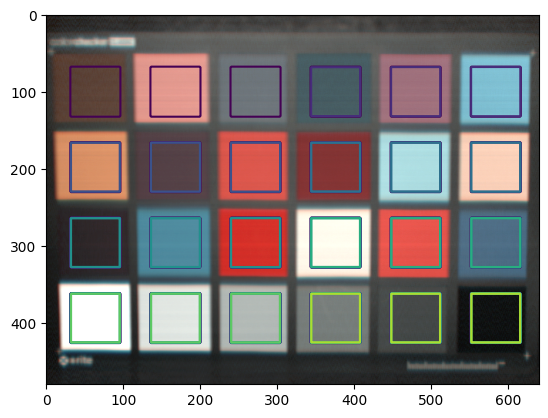

In [4]:
mask = cc_reader.create_automask()
plt.imshow(cc_reader.img_dir.read_rgb_reconstructed())
plt.contour(mask);

In order to save a mask, the method *save_mask(mask)* needs to be called

In [5]:
# cc_reader.save_mask(mask) # uncomment this line to save the generated mask!

A successfully stored mask can be loaded together with a table containing for each color chip the median spectrum (and standard deviation) across all pixels within one square annotation as follows:

In [6]:
res_dict = img_dir.read_colorchecker_mask()
mask_loaded = res_dict["mask"]
df = res_dict["median_table"]
df.head()

,label_index,label_name,label_color,row,col,median_spectrum,std_spectrum,median_normalized_spectrum,std_normalized_spectrum
0,1,dark_skin,#735244,0,0,"[0.06174746, 0.06352064, 0.06519801, 0.0666950...","[0.018592317, 0.014487812, 0.012549134, 0.0111...","[0.004799518, 0.004921727, 0.0050586816, 0.005...","[0.0014402167, 0.0011183475, 0.0009670889, 0.0..."
1,2,light_skin,#c29682,0,1,"[0.2576902, 0.27365655, 0.28167427, 0.27911356...","[0.01739441, 0.014941716, 0.013039938, 0.01169...","[0.004458234, 0.004724555, 0.004861873, 0.0048...","[0.0002992896, 0.00025330932, 0.0002224537, 0...."
2,3,blue_sky,#627a9d,0,2,"[0.21825933, 0.22183946, 0.22320089, 0.2201273...","[0.018274326, 0.014917207, 0.013082553, 0.0115...","[0.0075792046, 0.007709534, 0.0077541014, 0.00...","[0.0006382413, 0.0005146952, 0.00045296067, 0...."
3,4,foliage,#576c43,0,3,"[0.079294086, 0.08702226, 0.097314365, 0.10946...","[0.015106551, 0.011790854, 0.010326405, 0.0089...","[0.006275872, 0.0069028735, 0.007715497, 0.008...","[0.0012054711, 0.0009417319, 0.0008368157, 0.0..."
4,5,blue_flower,#8580b1,0,4,"[0.21896054, 0.2233795, 0.22517613, 0.22196864...","[0.018141543, 0.014751516, 0.012789232, 0.0111...","[0.004377637, 0.004463576, 0.0044963583, 0.004...","[0.00036525048, 0.0002975642, 0.00025827342, 0..."


## Part 2: Troubleshooting

### 2.1 Correction for wrong rotation angles

The optimal rotation angle can be manually determined by changing the parameter *rot_angle* and observing its effect on the image. To this end, an instance of the ColorcheckerReader class is initialized with the parameter *rot_angle* (in degrees) being set. Once the optimal rotation angle is found, the automatic mask creation can be tried.

Determined rotation angle: 0.50°


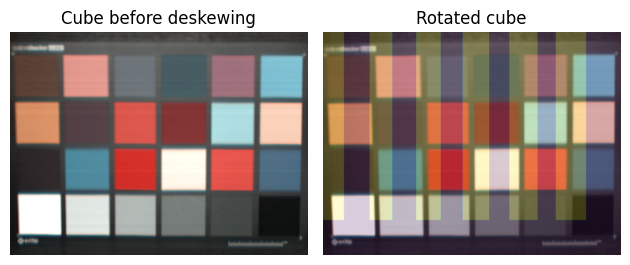

In [7]:
rot_angle = 0.5
cc_reader_rot = ColorcheckerReader(img_dir, cc_board, rot_angle)
print(f"Determined rotation angle: {cc_reader_rot.rot_angle:.2f}°")
visualize_rotation(cc_reader_rot);

### 2.2 Creation of a custom colorchecker mask

A single 4 x 6 colorchecker mask is determined through 5 parameters:
- *offset_left*: $x$-coordinate of the origin of the colorchecker mask
- *offset_top*: $y$-coordinate of the origin of the colorchecker mask
- *square_size*: edge length of the square annotation for an individual color chip
- *square_dist_vertical*: distance between neighboring square annotations along the $y$-axis
- *square_dist_horizontal*: distance between neighboring square annotations along the $x$-axis

<img src="colorchecker_mask_sketch.svg" width="800" />

The parameters of the automask can be read as follows:

In [8]:
cc_reader.mask_params

{'mask_0': {'offset_left': 32,
  'offset_top': 68,
  'square_dist_horizontal': 40,
  'square_dist_vertical': 34,
  'square_size': 64}}

By defining the parameter dict, a custom mask can be created:

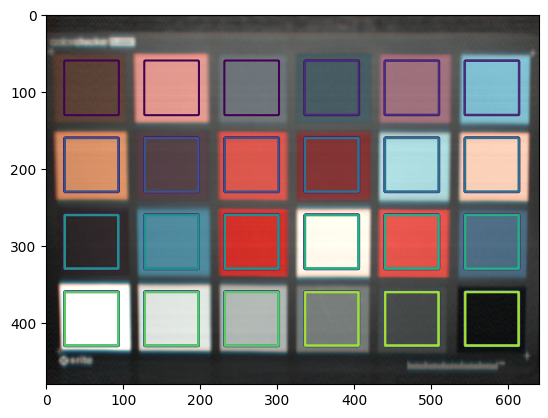

In [9]:
custom_mask_params = dict(
    square_size=70, square_dist_horizontal=34, square_dist_vertical=30, offset_top=60, offset_left=24
)

mask = cc_reader.create_mask({"mask_0": custom_mask_params})
plt.imshow(cc_reader.img_dir.read_rgb_reconstructed())
plt.contour(mask);